In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from entropy import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
## Load salinization and reference wetland datasets
#grab specific columns of interest
salt_cols = ['decday', 'datetime', 'wm_gf', 'wm', 'wc_gf', 'gpp_ANNnight', 'er_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'PRECIP', 'ustar', 'WT', 'H_gf', 'TW_WATER_10cm']

ref_cols = ['decday', 'datetime', 'wm_gf', 'wm', 'wc_gf', 'gpp_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'ustar', 'WT', 'H_gf', 'TW_8cm']

# import both datasets
salt = pd.read_csv('data/peat6_all.csv', usecols = salt_cols, 
                    index_col = 'datetime', parse_dates = True)

ref = pd.read_csv('data/peat19_all.csv', usecols = ref_cols,
                  index_col = 'datetime', parse_dates = True)

In [25]:
# Use only fully vegetated period
salt_sub = salt['2012': '2017']

# Calculate mutual information and shuffled surrogates for salinization wetland
Ta_MI, Ta_MImc = MI_timeseries(salt_sub['TA.y'], salt_sub['wm'], bins=10, normalize=True,
                               MC_runs = True, alpha=0.05, runs=10)

GPP_MI, GPP_MImc = MI_timeseries(salt_sub['gpp_ANNnight'], salt_sub['wm'], bins=10, normalize=True,
                               MC_runs = True, alpha=0.05, runs=10)

/Users/samchamberlain/salinity_py/entropy.py:21: RuntimeWarning: divide by zero encountered in log2
  return - np.sum(np.sum(j_probs * np.log2(j_probs)))
/Users/samchamberlain/salinity_py/entropy.py:11: RuntimeWarning: divide by zero encountered in log2
  return - np.sum(probs * np.log2(probs))


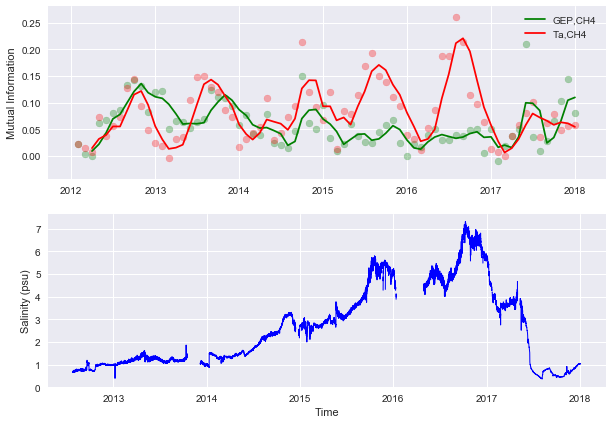

In [28]:
# Figure 1: Mutual information across time at salinization wetland

time_s = pd.date_range('2012', '2018', freq = 'M') # time array

#corrected MI (> 0 is sig. at P < 0.05)
GPP_MIc = GPP_MI - GPP_MImc
Ta_MIc = Ta_MI - Ta_MImc

fig, ax = plt.subplots(2, 1, figsize=(10, 7))

ax[0].scatter(time_s, GPP_MIc, color='green', alpha=0.3)
ax[0].scatter(time_s, Ta_MIc, color='red', alpha=0.3)
ax[0].plot(time_s, pd.Series(GPP_MIc).rolling(3).mean(), color='green', label = 'GEP,CH4')
ax[0].plot(time_s, pd.Series(Ta_MIc).rolling(3).mean(), color='red', label = 'Ta,CH4')
ax[0].set_ylabel('Mutual Information')
ax[0].legend()
ax[1].plot(salt_sub['sal'], color='blue', linewidth=1)
ax[1].set_ylabel('Salinity (psu)')
ax[1].set_xlabel('Time');

In [29]:
# Use only fully vegetated period
ref_sub = ref['2014': '2017']

# Calculate mutual information and shuffled surrogates for salinization wetland
Ta_R_MI, Ta_R_MImc = MI_timeseries(ref_sub['TA.y'], ref_sub['wm'], bins=10, normalize=True,
                               MC_runs = True, alpha=0.05, runs=10)

GPP_R_MI, GPP_R_MImc = MI_timeseries(ref_sub['gpp_ANNnight'], ref_sub['wm'], bins=10, 
                                     normalize=True, MC_runs = True, alpha=0.05, runs=10)

/Users/samchamberlain/salinity_py/entropy.py:11: RuntimeWarning: divide by zero encountered in log2
  return - np.sum(probs * np.log2(probs))
/Users/samchamberlain/salinity_py/entropy.py:21: RuntimeWarning: divide by zero encountered in log2
  return - np.sum(np.sum(j_probs * np.log2(j_probs)))


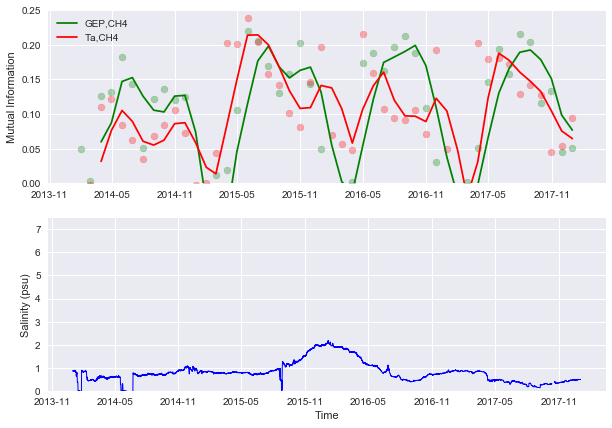

In [33]:
# Figure 2: Mutual information across time at salinization wetland

time_s = pd.date_range('2014', '2018', freq = 'M') # time array

#corrected MI (> 0 is sig. at P < 0.05)
GPP_R_MIc = GPP_R_MI - GPP_R_MImc
Ta_R_MIc = Ta_R_MI - Ta_R_MImc

fig, ax = plt.subplots(2, 1, figsize=(10, 7))

ax[0].scatter(time_s, GPP_R_MIc, color='green', alpha=0.3)
ax[0].scatter(time_s, Ta_R_MIc, color='red', alpha=0.3)
ax[0].plot(time_s, pd.Series(GPP_R_MIc).rolling(3).mean(), color='green', label = 'GEP,CH4')
ax[0].plot(time_s, pd.Series(Ta_R_MIc).rolling(3).mean(), color='red', label = 'Ta,CH4')
ax[0].set_ylabel('Mutual Information')
ax[0].set_ylim(0, 0.25)
ax[0].legend()
ax[1].plot(ref_sub['sal'], color='blue', linewidth=1)
ax[1].set_ylabel('Salinity (psu)')
ax[1].set_ylim(0, 7.5)
ax[1].set_xlabel('Time');

In [34]:
## Transfer entropy across multiple growing seasons of data

#Step 1: Apply anomaly filter
def anomaly_filter(x, window = 5): #five day filter as default
    return x - x.rolling(window).mean()

# data transformations to apply half-hourly anomaly filter
salt['time_of_day'] = salt.index.round('min').strftime('%H:%M')
salt.sort_values(['time_of_day', 'decday'], inplace=True)
salt['CH4_anom'] = anomaly_filter(salt['wm_gf'])
salt['GEP_anom'] = anomaly_filter(salt['gpp_ANNnight'])
salt['Ta_anom'] = anomaly_filter(salt['TA.y'])

salt.sort_index(inplace = True) #return to original order
#salt['CH4_anom'] = np.where(salt['wm'].isnull(), np.nan, salt['CH4_anom']) #insert NAs to reflect obs. only

#subset data to years of interest (2012-2013 and 2015-2016)
te_sub = salt['2012':'2016']
te_sub = te_sub[~(te_sub.index.year == 2014)]
te_sub.index.year.unique()

#finally, transfer entropy calculations
GEP_te, GEP_sig = TE_timeseries(te_sub['GEP_anom'], te_sub['CH4_anom'], lags=120, runs=2)
TA_te, TA_sig = TE_timeseries(te_sub['Ta_anom'], te_sub['CH4_anom'], lags=120, runs=2)

/Users/samchamberlain/salinity_py/entropy.py:21: RuntimeWarning: divide by zero encountered in log2
  return - np.sum(np.sum(j_probs * np.log2(j_probs)))
/Users/samchamberlain/salinity_py/entropy.py:34: RuntimeWarning: divide by zero encountered in log2
  return - np.sum(np.sum(j_probs * np.log2(j_probs)))
/Users/samchamberlain/salinity_py/entropy.py:11: RuntimeWarning: divide by zero encountered in log2
  return - np.sum(probs * np.log2(probs))


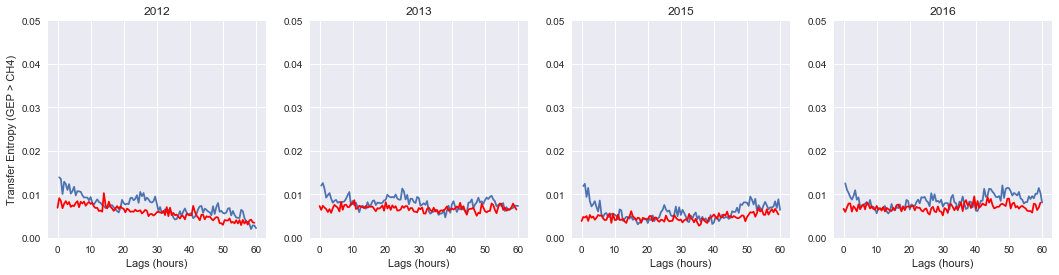

In [35]:
# Fig3a: Transfer entropy GEP to CH4 flux
years = te_sub.index.year.unique()
fig, ax = plt.subplots(1, len(years), figsize=(18, 4))

for i in range(len(years)):
    ax[i].plot(GEP_te.index/2, GEP_te.iloc[:, i])
    ax[i].plot(GEP_sig.index/2, GEP_sig.iloc[:, i], color='red')
    ax[i].set_ylim(0, 0.05)
    ax[i].set_title(TA_te.columns[i])
    ax[i].set_xlabel('Lags (hours)')
    ax[0].set_ylabel('Transfer Entropy (GEP > CH4)')

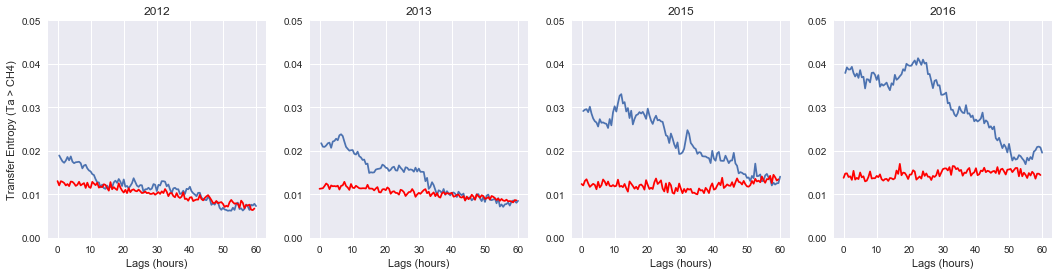

In [31]:
# Fig3b: Transfer entropy Tair to CH4 flux
years = te_sub.index.year.unique()
fig, ax = plt.subplots(1, len(years), figsize=(18, 4))

for i in range(len(years)):
    ax[i].plot(TA_te.index/2, TA_te.iloc[:, i])
    ax[i].plot(TA_sig.index/2, TA_sig.iloc[:, i], color='red')
    ax[i].set_ylim(0, 0.05)
    ax[i].set_title(TA_te.columns[i])
    ax[i].set_xlabel('Lags (hours)')
    ax[0].set_ylabel('Transfer Entropy (Ta > CH4)')

In [59]:
# setup random forest model w/ median imputation
forest = make_pipeline(Imputer(strategy='median'),
                       RandomForestRegressor(n_estimators=500))

param_grid = {'randomforestregressor__max_features': [2, 3, 4]}

forest_grid = GridSearchCV(forest, param_grid, cv=5) #five-fold cross-validation

In [60]:
#aggregate to daily time scale to train model
daily = salt.resample('D')['wm_gf', 'gpp_ANNnight', 'TA.y', 'PAR', 'VPD', 'PA.x', 'ustar'].mean()
daily['wm_gf'] = daily['wm_gf'] * 12.01 * 3600 * 24 / 1E6 #mg C m-2 d-1
daily['gpp_ANNnight'] = daily['gpp_ANNnight'] * 12.01 * 3600 * 24 / 1E6 #g C m-2 d-1

#split into pre- and post-salinity rise for model training and application
pre_rise = daily['2012':'2014'].copy()
post_rise = daily['2015':'2016'].copy()

Test R2 0.863072515535


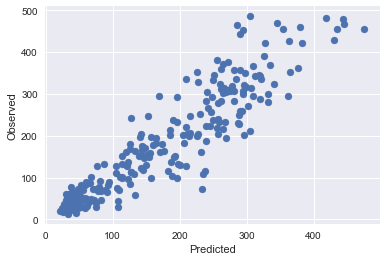

In [64]:
# Train the methane model and check quality against pre-rise test set
CH4_features = ['gpp_ANNnight', 'TA.y', 'VPD', 'PA.x', 'ustar'] #model features
X_ch4 = pre_rise[CH4_features]

# train, test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_ch4, pre_rise['wm_gf'], 
                                                random_state=0, test_size = 0.25)

CH4_forest = grid.fit(Xtrain, ytrain).best_estimator_ #fit the model...
CH4_out = CH4_forest.predict(Xtest) #fit against test set

#evaluate against test
plt.scatter(CH4_out, ytest)
plt.xlabel('Predicted'); plt.ylabel('Observed')
print('Test R2', r2_score(ytest, CH4_out))

Test R2 0.595357471072


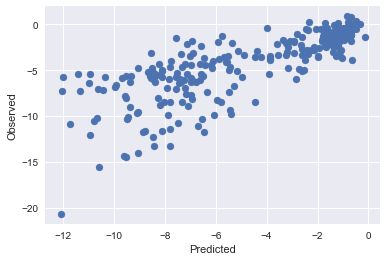

In [66]:
# Train the GEP model and evaluate against test set
GEP_features = ['PAR', 'TA.y', 'VPD', 'PA.x', 'ustar']
X_gep = pre_rise[GEP_features]

#train, test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_gep, pre_rise['gpp_ANNnight'],
                                                random_state=0, test_size=0.25)
#fitting and test predictions
GEP_forest = grid.fit(Xtrain, ytrain).best_estimator_
GEP_out = GEP_forest.predict(Xtest)

#plotting and evaluation
plt.scatter(GEP_out, ytest)
plt.xlabel('Predicted'); plt.ylabel('Observed')
print('Test R2', r2_score(ytest, GEP_out))

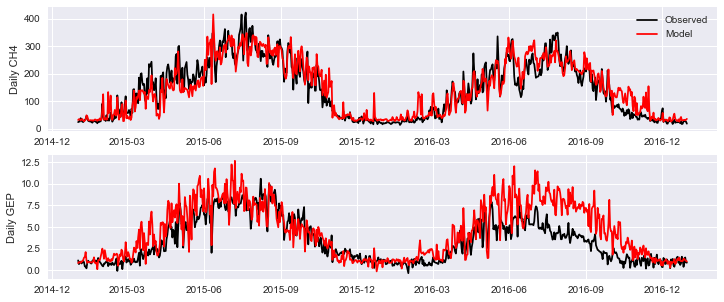

In [81]:
## Figure 4: Salinity 'naive' model predictions and observed fluxes

# predictions based on salinity 'naive' random forests
post_rise['CH4_naive'] = CH4_forest.predict(post_rise[CH4_features])
post_rise['GEP_naive'] = GEP_forest.predict(post_rise[GEP_features])

#plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 5))

ax[0].plot(post_rise['wm_gf'], color='black', label='Observed')
ax[0].plot(post_rise['CH4_naive'], color='red', label='Model')
ax[0].set_ylabel('Daily CH4')
ax[0].legend()
ax[1].plot(post_rise['gpp_ANNnight'] * -1, color='black')
ax[1].plot(post_rise['GEP_naive'] * -1, color='red')
ax[1].set_ylabel('Daily GEP');

In [101]:
# Calculate annual reductions in fluxes
annual = post_rise.resample('A').mean()

#unit conversions to annual sums
annual['gpp_ANNnight'] = annual['gpp_ANNnight'] * annual.index.dayofyear
annual['GEP_naive'] = annual['GEP_naive'] * annual.index.dayofyear
annual['wm_gf'] = annual['wm_gf'] * annual.index.dayofyear / 1000
annual['CH4_naive'] = annual['CH4_naive'] * annual.index.dayofyear / 1000

#percent reduction due to salinity influence
annual['CH4_delta'] = (annual['wm_gf'] / annual['CH4_naive'] - 1) * 100
annual['GEP_delta'] = (annual['gpp_ANNnight'] / annual['GEP_naive'] - 1) * 100

annual.head()

,wm_gf,gpp_ANNnight,TA.y,PAR,VPD,PA.x,ustar,CH4_naive,GEP_naive,CH4_delta,GEP_delta
datetime,,,,,,,,,,,
2015-12-31,58.329541,-1449.825943,16.099424,472.785796,0.775397,101.596269,0.410001,57.557215,-1643.436807,1.341841,-11.780852
2016-12-31,45.687493,-1001.302338,15.805928,467.130763,0.728316,101.574188,0.404482,49.989521,-1613.060083,-8.605859,-37.925292


In [25]:
sorted(forest.get_params().keys())

NameError: name 'forest' is not defined

In [26]:
GEP_sig

datetime,2012,2013,2015,2016
0,0.011347,0.009756,0.006153,0.008763
1,0.010347,0.009644,0.007872,0.008264
2,0.010175,0.009269,0.006462,0.009405
3,0.010478,0.009964,0.007182,0.008408
4,0.010241,0.010051,0.006139,0.008501
5,0.010077,0.010078,0.006602,0.008435
6,0.010080,0.008782,0.007386,0.008920
7,0.010725,0.008790,0.007569,0.009337
8,0.010583,0.009465,0.007636,0.008189
9,0.010968,0.009315,0.006895,0.009431


,decday,PA.x,ustar,wm,H_gf,wq_gf,wc_gf,wm_gf,er_ANNnight,gpp_ANNnight,...,PRECIP,PAR,WT,TW_WATER_10cm,VPD,sal,time_of_day,CH4_anom,GEP_anom,Ta_anom
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,731.0000,102.4,0.123120,NaN,0.15685,0.127480,0.43970,24.02420,2.1531,-1.713400,...,0.000,0.0000,114.6897,9.275,0.078042,NaN,00:00,NaN,-0.363790,-2.5448
2012-01-01 00:29:57,731.0208,102.4,0.097564,NaN,-0.98176,0.055194,0.59199,23.85540,2.2558,-1.663800,...,0.000,0.0000,114.6894,9.125,0.073259,NaN,00:30,NaN,-0.469622,-2.4026
2012-01-01 01:00:02,731.0417,102.4,0.109020,NaN,-0.28489,0.059639,0.59756,24.26030,2.2340,-1.636400,...,0.000,0.0000,114.6892,9.110,0.047779,NaN,01:00,NaN,-0.361593,-2.4842
2012-01-01 01:30:00,731.0625,102.4,0.094842,NaN,0.18619,0.012596,0.55032,23.65570,2.4085,-1.858200,...,0.000,0.0000,114.6890,8.975,0.043181,NaN,01:30,NaN,-0.479596,-2.7938
2012-01-01 01:59:57,731.0833,102.4,0.126170,NaN,0.33605,0.010254,0.55545,22.97800,2.1803,-1.624900,...,0.000,0.0000,114.6888,8.905,0.035808,NaN,02:00,NaN,-0.289104,-2.7692
2012-01-01 02:30:02,731.1042,102.5,0.121040,NaN,1.52690,-0.010793,0.50580,23.16540,2.1266,-1.620800,...,0.000,0.0000,114.6885,8.780,0.028723,NaN,02:30,NaN,-0.099760,-3.2262
2012-01-01 03:00:00,731.1250,102.5,0.134670,NaN,2.35300,0.004616,0.52382,23.07570,2.0805,-1.556700,...,0.000,0.0000,114.6883,8.655,0.024489,NaN,03:00,NaN,-0.269552,-3.1868
2012-01-01 03:29:57,731.1458,102.4,0.157820,NaN,11.14490,0.193750,0.64498,25.26390,2.1192,-1.474200,...,0.025,0.0000,114.6881,8.590,0.022883,NaN,03:30,NaN,-0.085416,-3.3660
2012-01-01 04:00:02,731.1667,102.5,0.188960,NaN,31.24610,0.260390,0.61216,25.49650,2.0503,-1.438200,...,0.050,0.0000,114.6878,8.460,0.022666,NaN,04:00,NaN,-0.248722,-3.2264
